# Potential Fields
Extrapolate some potential fields for use as initial conditions in a non-linear force-free field extrapolation.

In [1]:
import numpy as np
from solarbextrapolation.example_data_generator import generate_example_data,dummyDataToMap
from solarbextrapolation.extrapolators import PotentialExtrapolator
import astropy.units as u
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import synthesizAR
from sunpy.map import Map
import yt

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Fractured Dipole

First, we need to set up the synthetic magnetogram. Configure the grid shape and spatial ranges for the $x$ and $y$ dimensions.

In [2]:
arr_grid_shape = [ 300, 300]
xrange = u.Quantity([ -150.0, 150.0 ] * u.arcsec)
yrange = u.Quantity([ -150.0, 150.0 ] * u.arcsec)

Set the field strength and locations of $B_z$.

In [3]:
# +/- 2e3 Gauss "spots" along the horizontal with a 5% spread
num_spots = 100
fraction = 1./num_spots
spots = []
for i in range(num_spots):
    rand_y_pos = 30 + 30*np.random.rand()
    rand_x_pos = 45 + 30*np.random.rand()
    spots.append(( u.Quantity([ rand_x_pos, rand_y_pos ] * u.percent), np.random.rand()*3.5 * u.percent,  fraction*5e3 * u.Gauss ))
    rand_y_neg = 65 - 30*np.random.rand()
    rand_x_neg = 60 - 30*np.random.rand()
    spots.append(( u.Quantity([ rand_x_neg, rand_y_neg ] * u.percent), np.random.rand()*3.5 * u.percent,  -fraction*5e3 * u.Gauss ))

Build the synthetic map.

In [4]:
delta_x = xrange[1] - xrange[0]
delta_y = yrange[1] - yrange[0]
dx = delta_x/arr_grid_shape[0]
dy = delta_y/arr_grid_shape[1]
synthetic_hmi_data = np.zeros(arr_grid_shape)
xphysical,yphysical = np.meshgrid(np.arange(arr_grid_shape[0])*dx,np.arange(arr_grid_shape[1])*dy)
for spot in spots:
    if spot[0].unit is u.percent:
        pos = u.Quantity([spot[0][0].value/100.*delta_x + xrange[0],
                          spot[0][1].value/100.*delta_y + yrange[0]])
    else:
        pos = spot[0]
    if spot[1].unit is u.percent:
        sigma = spot[1].value/100.*delta_x
    else:
        sigma = spot[1]
    An_max   = spot[2].value
    An_x     = pos[0]
    An_y     = pos[1]
    An_Dx    = xphysical - An_x + xrange[0]
    An_Dy    = yphysical - An_y + yrange[0]
    An_DxSqu = An_Dx.value**2.0
    An_DySqu = An_Dy.value**2.0
    An_Sigma = sigma.value

    # So this contibution is calculated and added.
    synthetic_hmi_data += An_max * np.exp( - ( (An_DxSqu + An_DySqu) / (2 * An_Sigma**2.0)) )

In [5]:
synthetic_hmi_map = dummyDataToMap(synthetic_hmi_data,xrange,yrange)

Fix up the metadata to avoid a bunch of annoying warnings.

In [6]:
test = Map('/home/wtb2/sunpy/data/hmi_m_45s_2010_09_29_23_52_30_tai_magnetogram.fits')
for key in ['ctype1','ctype2','rsun_ref','rsun_obs','dsun_ref','dsun_obs','wcsname','crlt_obs']:
    synthetic_hmi_map.meta[key] = test.meta[key]

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


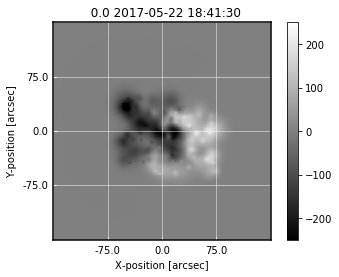

In [7]:
synthetic_hmi_map.peek(vmin=-250,vmax=250)

Set the height and box shape in the $z$-direction.

In [8]:
zshape=100
zrange=u.Quantity([0,300]*u.arcsec)

Resample to 100 by 100 grid.

In [9]:
resampled_synthetic_hmi_map = synthetic_hmi_map.resample(u.Quantity([100,100],u.pixel))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


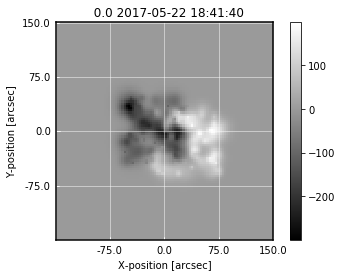

In [10]:
resampled_synthetic_hmi_map.peek()

Use `synthesizAR` package to extrapolate and trace the field lines.

In [11]:
field = synthesizAR.Skeleton(hmi_fits_file=resampled_synthetic_hmi_map)

In [12]:
field.extrapolate_field(zshape,zrange)

True


yt : [INFO     ] 2017-05-22 13:43:04,339 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-05-22 13:43:04,340 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-05-22 13:43:04,341 Parameters: domain_left_edge          = [ -1.02667363e+10  -1.02667363e+10   4.33805761e+08]
yt : [INFO     ] 2017-05-22 13:43:04,342 Parameters: domain_right_edge         = [  1.07728431e+10   1.07728431e+10   2.12564823e+10]
yt : [INFO     ] 2017-05-22 13:43:04,343 Parameters: cosmological_simulation   = 0.0


In [13]:
field.extract_streamlines(500)

yt : [INFO     ] 2017-05-22 13:43:04,788 AMRKDTree rebuilt, Final Volume: 9.217447e+30
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 412.60it/s]
yt : [INFO     ] 2017-05-22 13:43:06,743 AMRKDTree rebuilt, Final Volume: 9.217447e+30
Streamlining: 100%|██████████| 238/238 [00:00<00:00, 382.19it/s]
yt : [INFO     ] 2017-05-22 13:43:07,873 AMRKDTree rebuilt, Final Volume: 9.217447e+30
Streamlining: 100%|██████████| 114/114 [00:00<00:00, 374.18it/s]
yt : [INFO     ] 2017-05-22 13:43:08,575 AMRKDTree rebuilt, Final Volume: 9.217447e+30
Streamlining: 100%|██████████| 60/60 [00:00<00:00, 426.21it/s]
yt : [INFO     ] 2017-05-22 13:43:09,067 AMRKDTree rebuilt, Final Volume: 9.217447e+30
Streamlining: 100%|██████████| 26/26 [00:00<00:00, 338.88it/s]
yt : [INFO     ] 2017-05-22 13:43:09,457 AMRKDTree rebuilt, Final Volume: 9.217447e+30
Streamlining: 100%|██████████| 10/10 [00:00<00:00, 235.94it/s]
yt : [INFO     ] 2017-05-22 13:43:09,804 AMRKDTree rebuilt, Final Volume: 9.217447e+30
Streaml

Show the fieldlines traces.

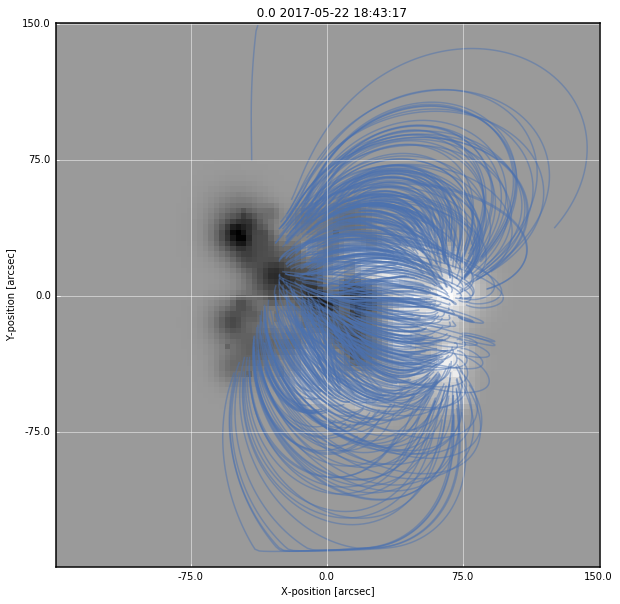

In [14]:
field.peek(alpha=0.5)

yt : [INFO     ] 2017-05-22 13:43:40,816 Projection completed
yt : [INFO     ] 2017-05-22 13:43:40,817 xlim = -10266736342.627728 10772843063.722858
yt : [INFO     ] 2017-05-22 13:43:40,819 ylim = -10266736342.660887 10772843063.689699
yt : [INFO     ] 2017-05-22 13:43:40,822 xlim = -10266736342.627728 10772843063.722858
yt : [INFO     ] 2017-05-22 13:43:40,823 ylim = -10266736342.660887 10772843063.689699
yt : [INFO     ] 2017-05-22 13:43:40,826 Making a fixed resolution buffer of (('stream', 'Bx')) 800 by 800
yt : [INFO     ] 2017-05-22 13:43:40,841 Making a fixed resolution buffer of (('stream', 'By')) 800 by 800
yt : [INFO     ] 2017-05-22 13:43:40,852 Making a fixed resolution buffer of (('stream', 'Bz')) 800 by 800
yt : [WARNING  ] 2017-05-22 13:43:40,885 Plot image for field ('stream', 'Bx') has both positive and negative values. Min = -752957946226.560913, Max = 317991065600.916565.
yt : [WARNING  ] 2017-05-22 13:43:40,885 Switching to symlog colorbar scaling unless linear scal

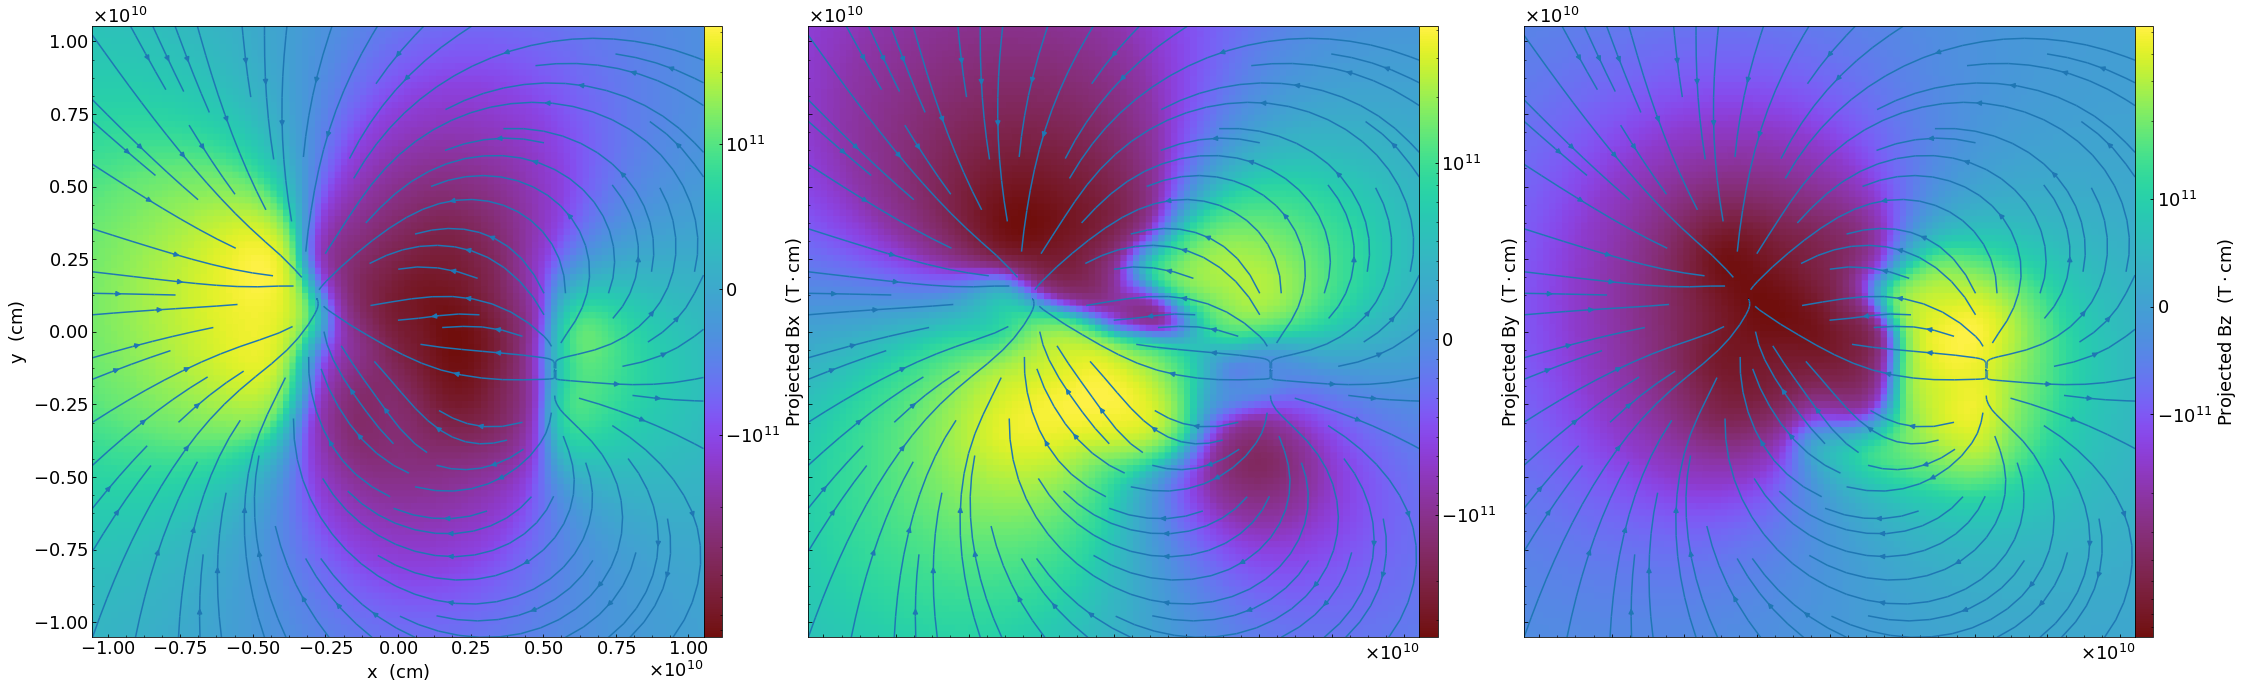

In [15]:
mag_fields = ['Bx','By','Bz']
fig = plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (1, 3),
                axes_pad = 1.2,
                label_mode = "1",
                share_all = True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%",
                cbar_pad="0%")
fig.set_figwidth(20)
p = yt.ProjectionPlot(field.extrapolated_3d_field,'z',mag_fields,origin='center-domain',axes_unit='cm')
p.annotate_streamlines('Bx','By')
p.figure_size = 30
for i,b_field in enumerate(mag_fields):
    plot = p.plots[b_field]
    plot.figure = fig
    plot.axes = grid[i].axes
    plot.cax = grid.cbar_axes[i]
p._setup_plots()
#p.show()

Print to file.

In [18]:
index_b_mapping = [(1,'bx'),(0,'by'),(2,'bz')]
fn_format = '/home/wtb2/Desktop/fractured_potential_field.{}'
for ibm in index_b_mapping:
	with open(fn_format.format(ibm[1]),'wb') as f:
		f.write(str.encode('// ny,nx,nz={}\n'.format(field._map_3d.data[:,:,:,ibm[0]].shape)))
		for i in range(field._map_3d.data[:,:,:,ibm[0]].shape[-1]):
			np.savetxt(f,field._map_3d.data[:,:,i,ibm[0]])
			f.write(b'////////////\n')


## HMI Magnetogram of NOAA 1109

In [19]:
field_hmi = synthesizAR.Skeleton(hmi_fits_file='/home/wtb2/sunpy/data/hmi_m_45s_2010_09_29_23_51_00_tai_magnetogram.fits',
                                 resample=u.Quantity([100,100],u.pixel),
                                 crop=(u.Quantity([110,610]*u.arcsec),u.Quantity([10,510]*u.arcsec)))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/image/transform.py:130: RuntimeWarning: Setting NaNs to 0 for higher-order scikit-image rotation
  RuntimeWarning)


In [20]:
field_hmi.extrapolate_field(zshape=100,zrange=[0,500]*u.arcsec)

True


yt : [INFO     ] 2017-05-22 13:59:37,785 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-05-22 13:59:37,786 Parameters: domain_dimensions         = [96 96 96]
yt : [INFO     ] 2017-05-22 13:59:37,787 Parameters: domain_left_edge          = [  8.88197442e+09   1.66007422e+09   7.23008497e+08]
yt : [INFO     ] 2017-05-22 13:59:37,788 Parameters: domain_right_edge         = [  4.35661688e+10   3.67055623e+10   3.54274164e+10]
yt : [INFO     ] 2017-05-22 13:59:37,789 Parameters: cosmological_simulation   = 0.0


In [21]:
field_hmi.extract_streamlines(500)

yt : [INFO     ] 2017-05-22 13:59:38,221 AMRKDTree rebuilt, Final Volume: 4.218406e+31
Streamlining: 100%|██████████| 500/500 [00:01<00:00, 419.71it/s]
yt : [INFO     ] 2017-05-22 13:59:40,179 AMRKDTree rebuilt, Final Volume: 4.218406e+31
Streamlining: 100%|██████████| 133/133 [00:00<00:00, 391.72it/s]
yt : [INFO     ] 2017-05-22 13:59:40,945 AMRKDTree rebuilt, Final Volume: 4.218406e+31
Streamlining: 100%|██████████| 32/32 [00:00<00:00, 384.44it/s]
yt : [INFO     ] 2017-05-22 13:59:41,355 AMRKDTree rebuilt, Final Volume: 4.218406e+31
Streamlining: 100%|██████████| 6/6 [00:00<00:00, 215.11it/s]
yt : [INFO     ] 2017-05-22 13:59:41,682 AMRKDTree rebuilt, Final Volume: 4.218406e+31
Streamlining: 100%|██████████| 1/1 [00:00<00:00, 52.43it/s]


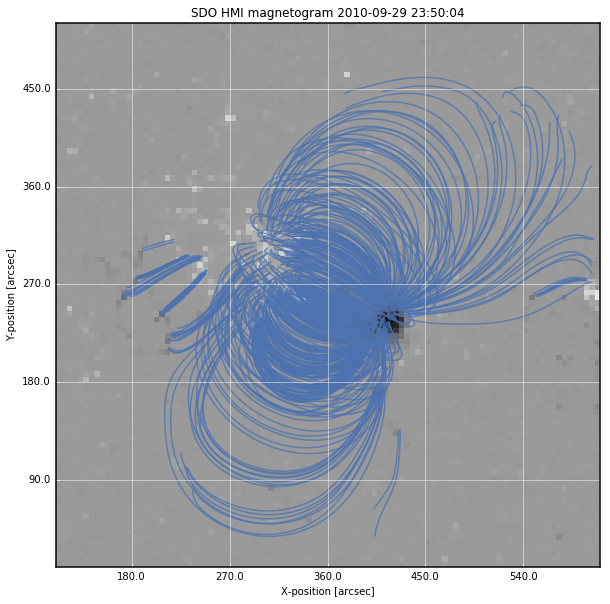

In [22]:
field_hmi.peek()

yt : [INFO     ] 2017-05-22 14:00:34,870 Projection completed
yt : [INFO     ] 2017-05-22 14:00:34,872 xlim = 8881974415.463547 43566168825.616135
yt : [INFO     ] 2017-05-22 14:00:34,873 ylim = 1660074222.444199 36705562324.369217
yt : [INFO     ] 2017-05-22 14:00:34,875 xlim = 8881974415.463547 43566168825.616135
yt : [INFO     ] 2017-05-22 14:00:34,876 ylim = 1660074222.444199 36705562324.369217
yt : [INFO     ] 2017-05-22 14:00:34,877 Making a fixed resolution buffer of (('stream', 'Bx')) 800 by 800
yt : [INFO     ] 2017-05-22 14:00:34,890 Making a fixed resolution buffer of (('stream', 'By')) 800 by 800
yt : [INFO     ] 2017-05-22 14:00:34,901 Making a fixed resolution buffer of (('stream', 'Bz')) 800 by 800
yt : [WARNING  ] 2017-05-22 14:00:34,934 Plot image for field ('stream', 'Bx') has both positive and negative values. Min = -163604726.565248, Max = 222061758.832133.
yt : [WARNING  ] 2017-05-22 14:00:34,935 Switching to symlog colorbar scaling unless linear scaling is specifi

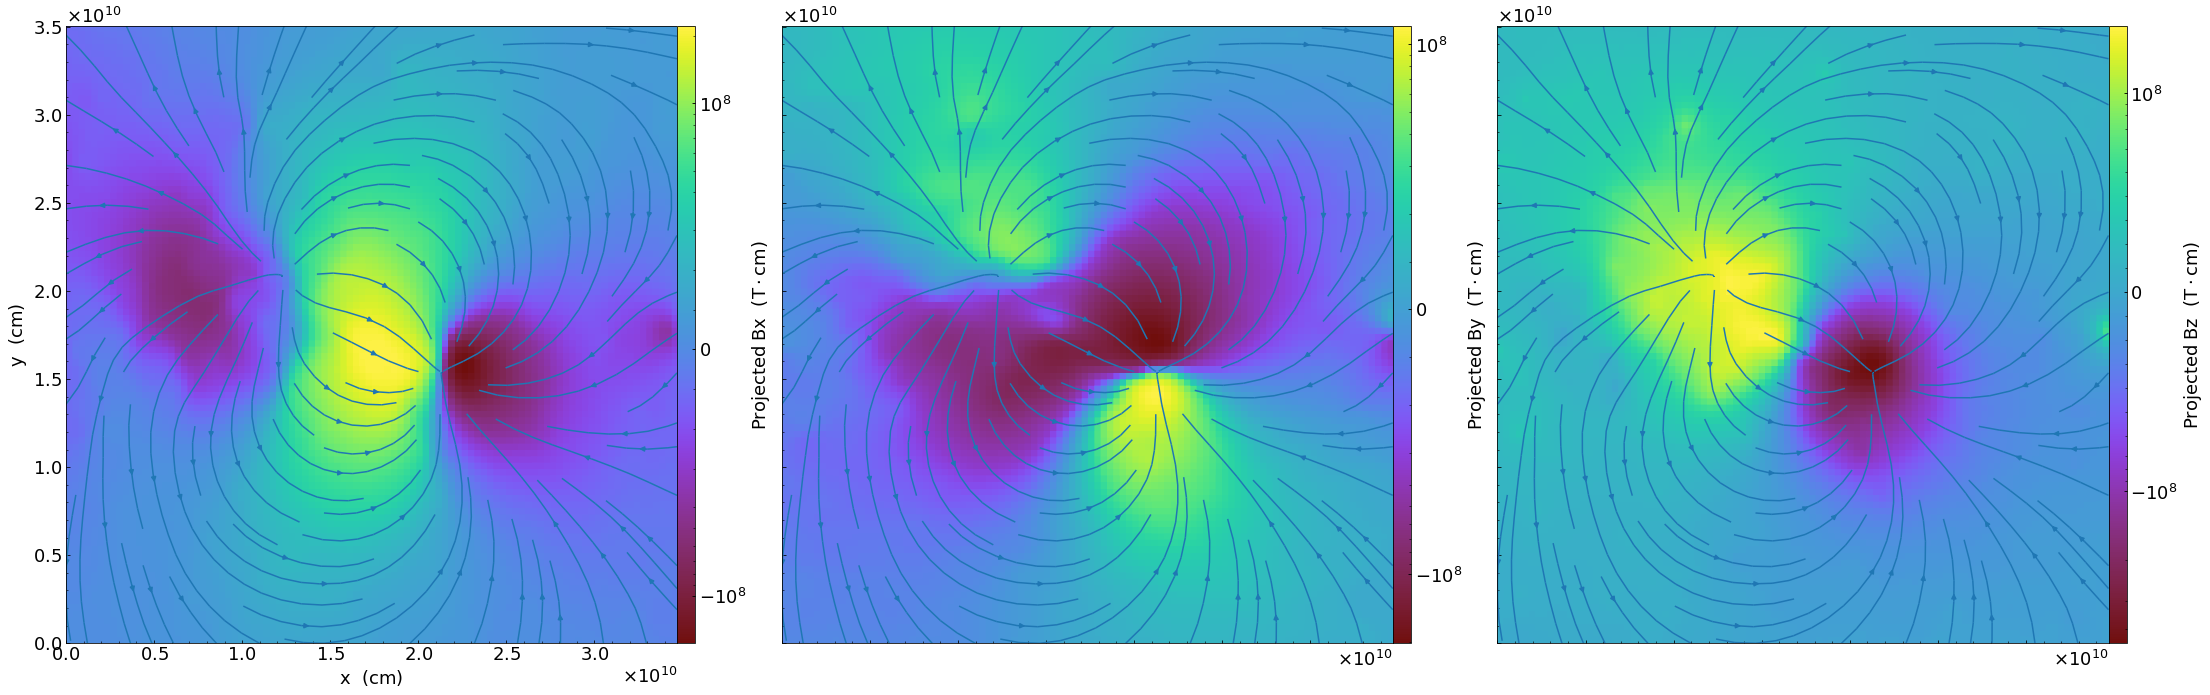

In [23]:
mag_fields = ['Bx','By','Bz']
fig = plt.figure()
grid = AxesGrid(fig, (0.075,0.075,0.85,0.85),
                nrows_ncols = (1, 3),
                axes_pad = 1.2,
                label_mode = "1",
                share_all = True,
                cbar_location="right",
                cbar_mode="each",
                cbar_size="3%",
                cbar_pad="0%")
fig.set_figwidth(20)
p = yt.ProjectionPlot(field_hmi.extrapolated_3d_field,'z',mag_fields,origin='domain',axes_unit='cm')
p.annotate_streamlines('Bx','By')
p.figure_size = 30
for i,b_field in enumerate(mag_fields):
    plot = p.plots[b_field]
    plot.figure = fig
    plot.axes = grid[i].axes
    plot.cax = grid.cbar_axes[i]
p._setup_plots()
#p.show()

Print to file.

In [24]:
index_b_mapping = [(1,'bx'),(0,'by'),(2,'bz')]
fn_format = '/home/wtb2/Desktop/hmi_noaa1109_potential_field.{}'
for ibm in index_b_mapping:
	with open(fn_format.format(ibm[1]),'wb') as f:
		f.write(str.encode('// ny,nx,nz={}\n'.format(field_hmi._map_3d.data[:,:,:,ibm[0]].shape)))
		for i in range(field_hmi._map_3d.data[:,:,:,ibm[0]].shape[-1]):
			np.savetxt(f,field_hmi._map_3d.data[:,:,i,ibm[0]])
			f.write(b'////////////\n')